In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import multiprocessing, pathos
import logging

## Notes on parallel processing

* **map** function chunks provided data array and executes chunks on separate processes. It has best possible performance, if all results must be present before the next step
* **imap** sends iterable results to processes on demand. Much slower than **map**. Use when whole dataset does not fit RAM, and must use real-time iterator instead of list for data source.
* **amap** is the same as **map**, except user gets access to some results that have already been processed before all of them are processed. May be useful in case of several step pipeline, but I have not yet seen a good example.

In [22]:
def very_math(x, size):
     return np.sum([np.sin(np.log(i*x+1)) for i in range(2, size)], axis=0)
    
taskThis = lambda param: very_math(*param)

nCore 1 task size 100 time was 0.2551615238189697
nCore 1 task size 1000 time was 2.238142490386963
nCore 1 task size 10000 time was 21.36579656600952
nCore 2 task size 100 time was 0.13701200485229492
nCore 2 task size 1000 time was 1.1478989124298096
nCore 2 task size 10000 time was 11.066621541976929
nCore 3 task size 100 time was 0.1081995964050293
nCore 3 task size 1000 time was 0.7668857574462891
nCore 3 task size 10000 time was 7.4292473793029785
nCore 4 task size 100 time was 0.07659363746643066
nCore 4 task size 1000 time was 0.5710108280181885
nCore 4 task size 10000 time was 5.613415241241455
nCore 5 task size 100 time was 0.07877922058105469
nCore 5 task size 1000 time was 0.6172778606414795
nCore 5 task size 10000 time was 5.930357933044434
nCore 6 task size 100 time was 0.083953857421875
nCore 6 task size 1000 time was 0.604560136795044
nCore 6 task size 10000 time was 5.71800684928894
nCore 7 task size 100 time was 0.07182002067565918
nCore 7 task size 1000 time was 0.58

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


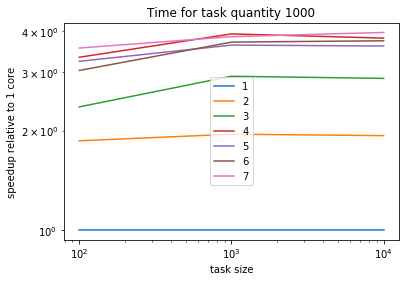

In [26]:
#####################################
# Test 1.1 Scaling with task size
#####################################
nTasks = 1000
taskSizeLst = [100, 1000, 10000]
nCoreLst = np.arange(1, pathos.multiprocessing.cpu_count())

timesTest11 = np.zeros((len(nCoreLst), len(taskSizeLst)))
for iCore, nCore in enumerate(nCoreLst):
    pool = pathos.multiprocessing.ProcessingPool(nCore)
    dataList = [[(x, taskSize) for x in range(nTasks)] for taskSize in taskSizeLst]
    for iTest, data in enumerate(dataList):
        t = time()
        results_mp = pool.map(taskThis, data)
        timesTest11[iCore, iTest] = time() - t
        print('nCore', nCore, 'task size', taskSizeLst[iTest], 'time was', timesTest11[iCore, iTest])
    
plt.figure()
for iCore, nCore in enumerate(nCoreLst):
    plt.loglog(taskSizeLst, timesTest11[0] / timesTest11[iCore], label=str(nCore))
plt.title('Time for task quantity '+str(nTasks))
plt.xlabel('task size')
plt.ylabel('speedup relative to 1 core')
plt.legend()
plt.show()

In [2]:
#####################################
# Test 1.2 Scaling with task quantity
#####################################
taskSize = 1000
nTasksLst = [100, 1000, 10000]
nCoreLst = np.arange(1, pathos.multiprocessing.cpu_count())

timesTest12 = np.zeros((len(nCoreLst), len(nTasksLst)))
for iCore, nCore in enumerate(nCoreLst):
    pool = pathos.multiprocessing.ProcessingPool(nCore)
    dataList = [[(x, taskSize) for x in range(nTasks)] for nTasks in nTasksLst]
    for iTest, data in enumerate(dataList):
        t = time()
        results_mp = pool.map(taskThis, data)
        timesTest12[iCore, iTest] = time() - t
        print('nCore', nCore, 'task quantity', nTasksLst[iTest], 'time was', timesTest12[iCore, iTest])
    
plt.figure()
for iCore, nCore in enumerate(nCoreLst):
    plt.loglog(nTasksLst, timesTest12[0] / timesTest12[iCore], label=str(nCore))
plt.title('Time for task size '+str(taskSize))
plt.xlabel('task quantity')
plt.ylabel('speedup relative to 1 core')
plt.legend()
plt.show()

NameError: name 'taskThis' is not defined

## Logging using multiprocessing

In [3]:
def task(x):
#     logger = logging.getLogger('MyLogger ' + str(multiprocessing.current_process()._identity[0]))
#     logger.setLevel(logging.DEBUG)
#     logger.addHandler(fh)
    thisID = multiprocessing.current_process()._identity[0]
    loggerSlave.info("Process " + str(thisID) + ": Processing stuff " + x)
#     logger.removeHandler(fh)
    return 1


for iJob in range(3):
    # Create file handler
    fh = logging.FileHandler('log'+str(iJob)+'.txt')
    fh.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
    fh.setFormatter(formatter)
    
    # Create loggers
    loggerMaster = logging.getLogger('master')
    loggerSlave = logging.getLogger('slave')
    loggerMaster.setLevel(logging.INFO)
    loggerSlave.setLevel(logging.INFO)
    
    # Add file handlers to loggers
    loggerMaster.addHandler(fh)
    loggerSlave.addHandler(fh)
    
    loggerMaster.info('Starting some stuff')
    
    pool = multiprocessing.Pool(7)
    results_mp = pool.map(task, list("aalkfnalkgnlkaerngnarngkwlekfwebkwr"))
    
    # Cleanup phase
    pool.close()
    pool.join()
    loggerMaster.removeHandler(fh)
    loggerSlave.removeHandler(fh)
    
    print(results_mp)
# logging.shutdown()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [5]:
def task(x):
    #thisID = pathos.core.getpid()
    thisID = multiprocessing.current_process()._identity[0]
    logger.info("Process " + str(thisID) + ": Processing stuff " + x)
    return 1


for iJob in range(3):
    # Create file handler
    fh = logging.FileHandler('log'+str(iJob)+'_pathos.txt')
    fh.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
    fh.setFormatter(formatter)
    
    #logger = pathos.logger(level=logging.DEBUG, handler=fh)
    logger = logging.getLogger("MyLogger")
    logger.setLevel(logging.DEBUG)
    logger.addHandler(fh)
    
    pool = multiprocessing.Pool(7)
    #pool = pathos.multiprocessing.ProcessingPool(7)
    results_mp = pool.map(task, list("aalkfnalkgnlkaerngnarngkwlekfwebkwr"))
    
    logger.removeHandler(fh)
    
    print(results_mp)
# logging.shutdown()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
def task(x):
    logger = logging.getLogger('MyLogger ' + str(multiprocessing.current_process()._identity[0]))
    logger.setLevel(logging.DEBUG)
    logger.addHandler(fh)
    logger.info("Processing stuff " + x)
    logger.removeHandler(fh)
    return 1


for iJob in range(3):
    fh = logging.FileHandler('log'+str(iJob)+'.txt')
    fh.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
    fh.setFormatter(formatter)

    logger = logging.getLogger('master')
    logger.addHandler(fh)
    logger.info('Starting some stuff')
    logger.removeHandler(fh)
    
    pool = multiprocessing.Pool(7)
    results_mp = pool.map(task, list("aalkfnalkgnlkaerngnarngkwlekfwebkwr"))
    pool.close()
    pool.join()
    print(results_mp)
logging.shutdown()

## Logging using Pathos

In [2]:
def task(x):
    logger = logging.getLogger(str(pathos.core.getpid()))
    logger.info("Processing stuff " + x)
    return 1

for iJob in range(3):
    # set up logging to file - see previous section for more details
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(name)-6s %(levelname)-8s %(message)s',
                        datefmt='%H:%M:%S',
                        filename='log'+str(iJob)+'.txt',
                        filemode='w')

    logger = logging.getLogger('master')
    logger.info('Starting some stuff')
    pool = pathos.multiprocessing.ProcessingPool(7)
    results_mp = pool.map(task, list("aalkfnalkgnlkaerngnarngkwlekfwebkwr"))
    logging.shutdown()
    print(results_mp)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [4]:
logger = pathos.logger()
logger.setLevel(logging.INFO)
logger.info("ALSJDASKD")

ALSJDASKD


In [36]:
import logging
import multiprocessing
 
from multiprocessing import Process, Lock
 
def printer(item, lock):
    """
    Prints out the item that was passed in
    """
    lock.acquire()
    try:
        print(item)
    finally:
        lock.release()
 
if __name__ == '__main__':
    lock = Lock()
    items = ['tango', 'foxtrot', 10]
    multiprocessing.log_to_stderr()
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    for item in items:
        p = Process(target=printer, args=(item, lock))
        p.start()

[INFO/Process-1] child process calling self.run()


tango


[INFO/Process-1] process shutting down
[INFO/Process-2] child process calling self.run()
[INFO/Process-1] process exiting with exitcode 0


foxtrot


[INFO/Process-2] process shutting down
[INFO/Process-3] child process calling self.run()
[INFO/Process-2] process exiting with exitcode 0


10


[INFO/Process-3] process shutting down
[INFO/Process-3] process exiting with exitcode 0


In [1]:
import logging

# with open('log.txt', 'w') as f:
#     pass

# set up logging to file - see previous section for more details
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M',
                    filename='log.txt',
                    filemode='w')

def task(x):
    logger = logging.getLogger('MyLogger')
    logger.info('Jackdaws love my big sphinx of quartz.')
    

logger = logging.getLogger('MyLogger1')
logger.info('Jackdaws love my big sphinx of quartz.')
#logging.info('Jackdaws love my big sphinx of quartz.')

# # create logger with 'spam_application'
# logger = logging.getLogger('MyLogger1')
# logger.setLevel(logging.INFO)
# # create file handler which logs even debug messages
# fh = logging.FileHandler('log.txt')
# fh.setLevel(logging.INFO)
# logger.addHandler(fh)

# Now, we can log to the root logger, or any other logger. First the root...


In [30]:
import logging
from logging import getLogger, info

with open('log.txt', 'w') as f:
    f.write("Starts here\n")

# set up logging to file - see previous section for more details
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M',
                    filename='log.txt',
                    filemode='w')

def task(x):
    #logger = logging.getLogger('MyLogger ' + str(pathos.core.getpid()))
    logger = logging.getLogger('MyLogger ' + str(multiprocessing.current_process()._identity[0]))
    logger.info("Processing stuff " + x)
    return 1
    
logger = logging.getLogger('MyLogger1')
logger.info('Jackdaws love my big sphinx of quartz.')

pool = multiprocessing.Pool(7)
results_mp = pool.map(task, list("aalkfnalkgnlkaerngnarngkwlekfwebkwr"))
print(results_mp)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
